# Initialize

Includes the `add_recommendations` helper function, which queries TMDb for recommendations and adds the results to the Ingestion Database.

In [1]:
from bmb import IngestionDB, ProcessingDB
import random
from bmb.source.webscraping.tmdb_access import get_tmdb_recommendations
from tqdm.notebook import tqdm

processing = ProcessingDB()
ingestion  = IngestionDB()

def add_recommendations( title, year):
    base_film_id = ingestion.id( "TMDbFilm", title, year, insert_new=True)
    if not ingestion.select_one( 'rec_search_date', "TMDbFilm", id=base_film_id):
        base_film_id    = ingestion.id( "TMDbFilm", title, year, insert_new=True)
        recommendations = get_tmdb_recommendations( title, year)
        for rec_title, rec_year in recommendations:
            recommendation_id = ingestion.id( "TMDbFilm", rec_title, rec_year, insert_new=True)
            ingestion.insert( "TMDbRecommendation", from_film=base_film_id, to_film=recommendation_id)
        ingestion.set( "UPDATE TMDbFilm SET rec_search_date=? WHERE id=?", ingestion.date_str, base_film_id)
        return recommendations
    return None

# Acquire Recommendations

Just a loop to call `add_recommendations` repeatedly.

In [2]:
titleyears = processing.get( """
SELECT title, year
FROM Film
WHERE 
status=1
ORDER BY year ASC
""")

for title, year in tqdm(titleyears):
    recs = add_recommendations( title, year)
    if recs:
        print( f"Found {len( recs)} recommendations for {title} ({year})")

  0%|          | 0/21260 [00:00<?, ?it/s]

Found 2 recommendations for Crack: Cocaine, Corruption & Conspiracy (2021)
Found 19 recommendations for Creating The Queen's Gambit (2021)
Found 6 recommendations for Dave Chappelle: The Closer (2021)
Found 1 recommendations for Diana: The Musical (2021)
Found 3 recommendations for Escape The Undertaker (2021)
Found 21 recommendations for Fear Street: Part One - 1994 (2021)
Found 21 recommendations for Fear Street: Part Two - 1978 (2021)
Found 1 recommendations for My Heroes Were Cowboys (2021)
Found 14 recommendations for My Little Pony: A New Generation (2021)
Found 2 recommendations for Nate Bargatze: The Greatest Average American (2021)
Found 21 recommendations for One (2021)
Found 1 recommendations for Antidote (2021)
Found 10 recommendations for Bingo Hell (2021)
Found 21 recommendations for Black as Night (2021)
Found 2 recommendations for Dawn of the Beast (2021)


# Transfer Movies to Processing Database

This opeation takes a while, since there over 24,000 films.  A lot of it is wasted effored, since most of the films have been previously transferred to the Processing Database, so in a future iteration of the project, I'll have a `transferredToProcessing` flag or something similar to speed this up.

In [3]:
tmdb_movies = ingestion.select( 'title', 'year', 'TMDbFilm')
print( f"{len(tmdb_movies)} movies from TMDb recommendations")
print( f"Transferring to Processing Database...")
for title, year in tqdm( tmdb_movies):
    processing.Film( title, year)

26146 movies from TMDb recommendations
Transferring to Processing Database...


  0%|          | 0/26146 [00:00<?, ?it/s]

# Load Info for New Films

`unverified` will contain all films the the Processing Database for which there has not been a basic information search.

In [4]:
unverified = processing.unverified_films
print( f"{len(unverified)} films not already in database")
print( "Looking up info...")
for film_id in tqdm( unverified):
    processing.lookup_film_info( film_id)

103 films not already in database
Looking up info...


  0%|          | 0/103 [00:00<?, ?it/s]

# Pie Chart: How'd it go?

Let's visualize the status of the films that were just added to the database.  There are several possible outcomes to each TMDb search:
* `basic info` is what we hope to see for the majority of films, and indicates that we now have basic information about the film.
* `TMDb search failure` can occur if the title/ year combination represents an artistic work other than a film, if the release year is wrong, etc.
* `foreign language hold` is a status assigned to films that were not originally released in English.  Foreign cinema will require special filters (e.g. the rules I use to find Chinese Martial Arts films would not necessarily transfer to English-language Martial Arts films, which came later and had a different production structure), so I'm freezing these films for now.

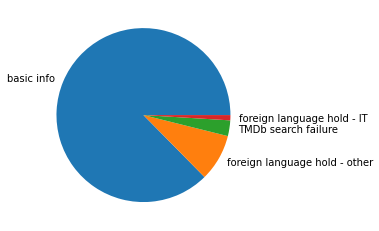

In [5]:
from matplotlib import pyplot as plt

QUERY = f"""
SELECT s.text, COUNT( f.id) as cnt
FROM Film f JOIN Status s ON f.status=s.id
WHERE f.id IN ({','.join('?'*len(unverified))})
GROUP BY f.status
ORDER BY cnt DESC
"""

labels, values = zip( *processing.get( QUERY, *unverified))
plt.pie( values, labels=labels)
plt.show()